In [46]:
import ultralytics
import os
import random
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import cv2 as cv

Yolo solves the problem of rotation and scaling issues when it comes to Localizing objects in images. 

While localizing objects in an image, we could have a fixed kernel move through the image pixel by pixel (stride-wise) and check if the object's features are present in the kernel and then bound it. This process called Sliding window. 
But this is highly expensive and will fail due to Scaling and Rotation issues. (When the object is smaller than said kernel's size, it won't recognize it).  

In essence, its an algorithm that aims to minimize the loss while drawing bounding boxes while classifying multiple images and obviously identify/localize/classify multiple objects in an image.

Theory :

Traditional Yolo architecture divides the image into a 7x7 grid where each grid is required to have only 1 object's centre at most. We do this by refining the grid and essentially increasing the number of grids from 7x7 to maybe 11x11 or something like that. 

Each pixel (point) on the grid is normalized to stay between 0 and 1. So each point can be (0,0) to (1,1).

Each grid has a vector associated with it that corresponds to the object class, confidence value, probability and position coordinates of the object. So for instance, if a grid has no object, the probability value is 0 and other parameters don't matter.

Note: If a certain grid has a part of some object that's not the centre of the object, the probability value is 0. Basically the vector has probability is 1 when a particular grid has the centre of the object. 

The vector looks like this : [p1 , bx , by . bw , bh ,
                             p2 , bx , by , bw , bh ,
                             c1 , c2 , c3] (for 3 classes). 
                             
Essecntially, we have 2 bounding boxes per grid cell and whichever is more accurate, we take that bounding box and consequently that object. During training, it considers 2 boxes and uses the one that gets the better confidence score. 

bx is the x-axis position of the centre of said object with repect to the top left corner of the grid.
by is the y-axis position of the centre of said object with repect to the top left corner of the grid.
c_ refers to the class of the object. 
p refers to the probability. 
bw and bh refer to the length and height of the bounding box (may or may not be more than 1).

So we get a long vector for each grid cell: (5 x B) + C. 

Hence in the end we get S x S x (5B + C) values for all the grid cells in the image. 
 
Essentially, we are trying to guess two places in the grid where the box might be taking the one with a higher confidence score. 

Only one of the bounding boxes is responsible for the probability and class score of that grid cell. 
This is chosen with the highest IOU (intersection over union with the ground truth box) score.
IOU measures the overlap between each of the bounding and the ground truth box. 
IOU = Area of overlap / Area of Union. Higher IOU directly means overlap = union, hence making a particular bounding box a tight exact fit for the object. 

Loss : There are 3 major components to the loss used in Yolo.
Localization loss - Model minimizes the x and y offset losses of the responsible bounding box.
Confidence loss - Tunes the model to predict how good the fit of the box is.
Classification loss - Tunes the model to predict the correct class in each grid cell.
All losses are MSE.

Anchor boxes : 
Its reasonable to assume that some objects' bounding boxes lie in a certain way. Like a person's bounding box will lie as a vertical rectangle and a car's will be a horizontal rectangle.
Having pre-defined anchor boxes lets us have multiple objects in the same grid, thereby reducing computation. 

Anchor boxes have been implemented from Yolo2 onwards to reduce complexity and improve multiple object detection.


In [25]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt") 

In [21]:
SOURCE_DIR = "cows_labels"  
DEST_DIR = "dataset"         
SPLIT_RATIO = 0.85                
IMG_EXT = [".jpg", ".jpeg", ".png"]

image_files = [f for f in os.listdir(SOURCE_DIR) if Path(f).suffix.lower() in IMG_EXT]
random.shuffle(image_files)

split_index = int(len(image_files) * SPLIT_RATIO)
train_files = image_files[:split_index]
val_files = image_files[split_index:]

def copy_to_dest(files, split_type):
    for img_file in files:
        img_path = os.path.join(SOURCE_DIR, img_file)
        label_file = Path(img_file).with_suffix('.txt')
        label_path = os.path.join(SOURCE_DIR, label_file)

        img_dest = os.path.join(DEST_DIR, 'images', split_type, img_file)
        label_dest = os.path.join(DEST_DIR, 'labels', split_type, label_file)

        shutil.copy2(img_path, img_dest)

        if os.path.exists(label_path):
            shutil.copy2(label_path, label_dest)
        else:
            print(f"Warning: Label not found for {img_file}")

copy_to_dest(train_files, 'train')
copy_to_dest(val_files, 'val')

print("Done")


Done


In [27]:
model.train(data = 'cow.yaml', epochs = 50 , imgsz = 640)

Ultralytics 8.3.166  Python-3.8.5 torch-2.4.1+cpu CPU (13th Gen Intel Core(TM) i7-13620H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cow.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile

100%|███████████████████████████████████████████████████████████████████████████████| 755k/755k [00:00<00:00, 4.11MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                


  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

train: Scanning C:\Users\sriha\Desktop\Srihari\Coding\Python\yolo_model\dataset\labels\train... 211 images, 0 backgroun

train: New cache created: C:\Users\sriha\Desktop\Srihari\Coding\Python\yolo_model\dataset\labels\train.cache
val: Fast image access  (ping: 0.10.0 ms, read: 314.5440.4 MB/s, size: 137.3 KB)



val: Scanning C:\Users\sriha\Desktop\Srihari\Coding\Python\yolo_model\dataset\labels\val... 59 images, 0 backgrounds, 0

val: New cache created: C:\Users\sriha\Desktop\Srihari\Coding\Python\yolo_model\dataset\labels\val.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G     0.9275      2.096      1.328          9        640: 100%|██████████| 14/14 [04:51<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<0

                   all         59         72          1      0.281      0.824      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.9384      1.354      1.342         14        640: 100%|██████████| 14/14 [04:40<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<0

                   all         59         72      0.916      0.607      0.817      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      0.941      1.365      1.392          7        640: 100%|██████████| 14/14 [04:18<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<0

                   all         59         72      0.631       0.45        0.5       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.066      1.384      1.429         12        640: 100%|██████████| 14/14 [04:26<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<0

                   all         59         72      0.704      0.659      0.702      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.072      1.337      1.399         13        640: 100%|██████████| 14/14 [04:22<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<0

                   all         59         72      0.365      0.417      0.312      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G       1.09      1.372      1.454          5        640: 100%|██████████| 14/14 [04:27<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:29<0

                   all         59         72      0.297      0.278      0.206      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.142      1.402      1.513          7        640: 100%|██████████| 14/14 [04:23<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:35<0

                   all         59         72      0.575      0.597      0.604      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.056      1.282      1.419          7        640: 100%|██████████| 14/14 [04:22<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:28<0

                   all         59         72      0.642      0.653      0.654      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.084      1.259      1.431         10        640: 100%|██████████| 14/14 [04:22<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<0

                   all         59         72       0.61      0.556      0.573      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.057        1.2      1.442         10        640: 100%|██████████| 14/14 [04:22<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<0

                   all         59         72      0.613       0.75      0.735      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.116      1.167      1.442          9        640: 100%|██████████| 14/14 [04:23<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<0

                   all         59         72      0.813      0.583      0.664      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.109      1.178      1.463          8        640: 100%|██████████| 14/14 [04:22<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<0

                   all         59         72      0.621      0.681       0.69      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.032      1.093      1.412          8        640: 100%|██████████| 14/14 [04:29<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<0

                   all         59         72      0.775       0.75      0.791      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.014      1.012      1.363         14        640: 100%|██████████| 14/14 [04:22<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<0

                   all         59         72      0.709      0.744      0.785      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.9704      1.044       1.34          9        640: 100%|██████████| 14/14 [04:25<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<0

                   all         59         72      0.857       0.83      0.885      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.9711      1.052      1.404         14        640: 100%|██████████| 14/14 [04:22<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<0

                   all         59         72      0.848      0.778       0.85      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G       0.94     0.9589        1.3         19        640: 100%|██████████| 14/14 [04:36<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.704      0.694      0.776      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      0.939     0.9378      1.346          8        640: 100%|██████████| 14/14 [04:14<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<0

                   all         59         72       0.83      0.708      0.814      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.9543     0.8993      1.334         10        640: 100%|██████████| 14/14 [04:08<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<0

                   all         59         72      0.915      0.917      0.959      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.9531     0.8836      1.329         11        640: 100%|██████████| 14/14 [04:14<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.891      0.917      0.931      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.9704     0.9074      1.351         14        640: 100%|██████████| 14/14 [04:10<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.895      0.917      0.957      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      0.952     0.8754      1.354          9        640: 100%|██████████| 14/14 [04:17<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<0

                   all         59         72      0.838      0.933      0.943      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.8486     0.8268      1.294          9        640: 100%|██████████| 14/14 [04:16<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<0

                   all         59         72      0.874      0.917      0.955      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.8756     0.8105      1.257         13        640: 100%|██████████| 14/14 [04:04<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<0

                   all         59         72      0.883      0.931      0.953      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.9085     0.8303      1.297          7        640: 100%|██████████| 14/14 [03:53<00:00, 16.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<0

                   all         59         72      0.953      0.903      0.978      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.9425     0.7948      1.323          8        640: 100%|██████████| 14/14 [03:56<00:00, 16.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<0

                   all         59         72      0.972      0.968      0.989      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.8794      0.758      1.271         14        640: 100%|██████████| 14/14 [04:01<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<0

                   all         59         72          1      0.958      0.993      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.8947     0.7935      1.321         10        640: 100%|██████████| 14/14 [56:57<00:00, 244
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<0

                   all         59         72      0.971      0.958      0.973      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.8396     0.7156      1.249         11        640: 100%|██████████| 14/14 [03:59<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<0

                   all         59         72      0.958      0.958      0.965      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.8631     0.7823      1.273          6        640: 100%|██████████| 14/14 [03:58<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<0

                   all         59         72      0.957      0.972      0.984       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.8157     0.6919      1.226         14        640: 100%|██████████| 14/14 [04:05<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<0

                   all         59         72      0.955      0.986      0.982      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.8648     0.7079       1.27         14        640: 100%|██████████| 14/14 [04:01<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<0

                   all         59         72      0.931      0.986       0.98      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.8559      0.729      1.266          9        640: 100%|██████████| 14/14 [03:57<00:00, 16.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<0

                   all         59         72      0.997      0.972      0.985      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.7908     0.6615      1.211          9        640: 100%|██████████| 14/14 [04:06<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.986      0.979      0.994      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.7294     0.6295      1.178          8        640: 100%|██████████| 14/14 [03:59<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<0

                   all         59         72      0.989      0.972      0.995      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      0.744     0.6286      1.196          9        640: 100%|██████████| 14/14 [04:06<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<0

                   all         59         72      0.986      0.981      0.994      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.7858     0.6166      1.222         10        640: 100%|██████████| 14/14 [03:52<00:00, 16.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<0

                   all         59         72      0.945      0.961      0.991      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.7354     0.6058      1.165         10        640: 100%|██████████| 14/14 [04:23<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.972       0.98      0.993       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.7089     0.5711      1.167          8        640: 100%|██████████| 14/14 [04:08<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.959      0.986      0.992      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.7152       0.58       1.16          7        640: 100%|██████████| 14/14 [04:16<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.986      0.986      0.993      0.827


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.6285     0.6654      1.142          3        640: 100%|██████████| 14/14 [04:10<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<0

                   all         59         72      0.994      0.972      0.992      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      0.653     0.6126       1.13          6        640: 100%|██████████| 14/14 [04:10<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<0

                   all         59         72      0.986      0.972       0.99      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.6277     0.6027      1.164          3        640: 100%|██████████| 14/14 [04:20<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.973      0.985      0.992      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      0.619     0.5376      1.133          3        640: 100%|██████████| 14/14 [04:19<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.986      0.983      0.994      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.5943     0.5446      1.142          5        640: 100%|██████████| 14/14 [04:17<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.985      0.986      0.994      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.5808     0.4931      1.118          3        640: 100%|██████████| 14/14 [04:18<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.985      0.986      0.994      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.6341     0.5045      1.116          3        640: 100%|██████████| 14/14 [04:11<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<0

                   all         59         72      0.984      0.986      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.5976     0.4834      1.168          3        640: 100%|██████████| 14/14 [04:12<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.984      0.986      0.994      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.5432     0.4769       1.09          3        640: 100%|██████████| 14/14 [04:15<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.984      0.986      0.994      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.5118     0.4479      1.075          3        640: 100%|██████████| 14/14 [04:19<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:24<0

                   all         59         72      0.984      0.986      0.994      0.865



50 epochs completed in 4.788 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.3MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.166  Python-3.8.5 torch-2.4.1+cpu CPU (13th Gen Intel Core(TM) i7-13620H)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<0


WARNING ConfusionMatrix plot failure: 'outline'
WARNING ConfusionMatrix plot failure: 'outline'
                   all         59         72      0.984      0.986      0.994      0.865
Speed: 6.3ms preprocess, 270.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E290F21160>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [60]:
results = model("cow_test1.jpg")
results[0].show()


image 1/1 C:\Users\sriha\Desktop\Srihari\Coding\Python\yolo_model\cow_test1.jpg: 480x640 2 cows, 217.6ms
Speed: 2.3ms preprocess, 217.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)



image 1/1 C:\Users\sriha\Desktop\Srihari\Coding\Python\yolo_model\cow_test1.jpg: 480x640 1 sheep, 2 cows, 232.5ms
Speed: 6.0ms preprocess, 232.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


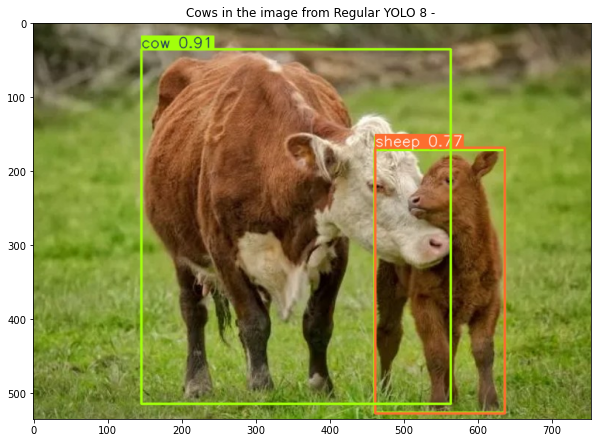

In [71]:
yolo8 = YOLO("yolov8n.pt")
results = yolo8("cow_test1.jpg")

img = cv.cvtColor(results[0].plot() , cv.COLOR_BGR2RGB)
plt.figure(figsize = (10,10) )
plt.imshow(img)
plt.title("Cows in the image from Regular YOLO 8 - ")
plt.show()


image 1/1 C:\Users\sriha\Desktop\Srihari\Coding\Python\yolo_model\cow_test1.jpg: 480x640 2 cows, 190.0ms
Speed: 4.8ms preprocess, 190.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


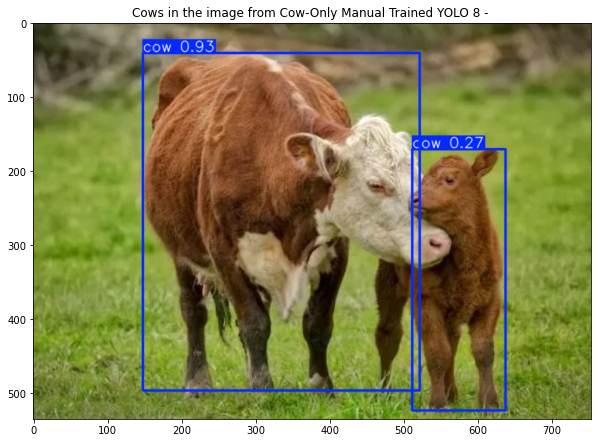

In [72]:
yolo_cow = YOLO("yolo8n_cow.pt")
results = yolo_cow("cow_test1.jpg")

img = cv.cvtColor(results[0].plot() , cv.COLOR_BGR2RGB)
plt.figure(figsize = (10,10) )
plt.imshow(img)
plt.title("Cows in the image from Cow-Only Manual Trained YOLO 8 - ")
plt.show()


image 1/1 C:\Users\sriha\Desktop\Srihari\Coding\Python\yolo_model\cow_test1.jpg: 480x640 2 cows, 250.1ms
Speed: 3.9ms preprocess, 250.1ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


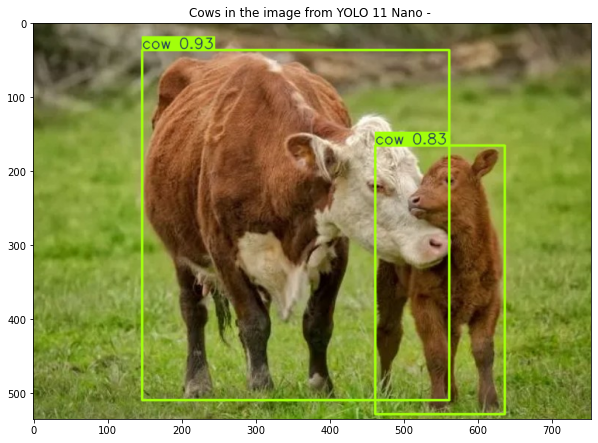

In [73]:
yolo_cow = YOLO("yolo11n.pt")
results = yolo_cow("cow_test1.jpg")

img = cv.cvtColor(results[0].plot() , cv.COLOR_BGR2RGB)
plt.figure(figsize = (10,10) )
plt.imshow(img)
plt.title("Cows in the image from YOLO 11 Nano - ")
plt.show()


image 1/1 C:\Users\sriha\Desktop\Srihari\Coding\Python\yolo_model\cow_test1.jpg: 480x640 2 cows, 4512.8ms
Speed: 7.6ms preprocess, 4512.8ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 640)


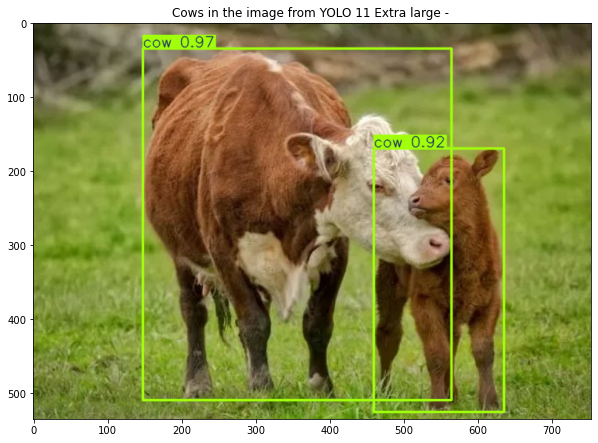

In [74]:
yolo_cow = YOLO("yolo11x.pt")
results = yolo_cow("cow_test1.jpg")

img = cv.cvtColor(results[0].plot() , cv.COLOR_BGR2RGB)
plt.figure(figsize = (10,10) )
plt.imshow(img)
plt.title("Cows in the image from YOLO 11 Extra large - ")
plt.show()